### Explore Bike Share Data

For this project, your goal is to ask and answer three questions about the available bikeshare data from Washington, Chicago, and New York.  This notebook can be submitted directly through the workspace when you are confident in your results.

You will be graded against the project [Rubric](https://review.udacity.com/#!/rubrics/2508/view) by a mentor after you have submitted.  To get you started, you can use the template below, but feel free to be creative in your solutions!

In [33]:
options(warn=-1)

library(ggplot2)
library(dplyr)
library(lubridate)

In [10]:
ny = read.csv('new_york_city.csv')
wash = read.csv('washington.csv')
chi = read.csv('chicago.csv')

In [11]:
head(ny, 1)

X,Start.Time,End.Time,Trip.Duration,Start.Station,End.Station,User.Type,Gender,Birth.Year
5688089,2017-06-11 14:55:05,2017-06-11 15:08:21,795,Suffolk St & Stanton St,W Broadway & Spring St,Subscriber,Male,1998


In [12]:
head(wash, 1)

X,Start.Time,End.Time,Trip.Duration,Start.Station,End.Station,User.Type
1621326,2017-06-21 08:36:34,2017-06-21 08:44:43,489.066,14th & Belmont St NW,15th & K St NW,Subscriber


In [13]:
head(chi, 1)

X,Start.Time,End.Time,Trip.Duration,Start.Station,End.Station,User.Type,Gender,Birth.Year
1423854,2017-06-23 15:09:32,2017-06-23 15:14:53,321,Wood St & Hubbard St,Damen Ave & Chicago Ave,Subscriber,Male,1992


### Question 1

How does trip duration change over time?

I'll start by looking at the summary statistics for `Trip.Duration`.

In [14]:
# Your solution code goes here
summary(chi$Trip.Duration)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   394.2   670.0   937.2  1119.0 85408.0 

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

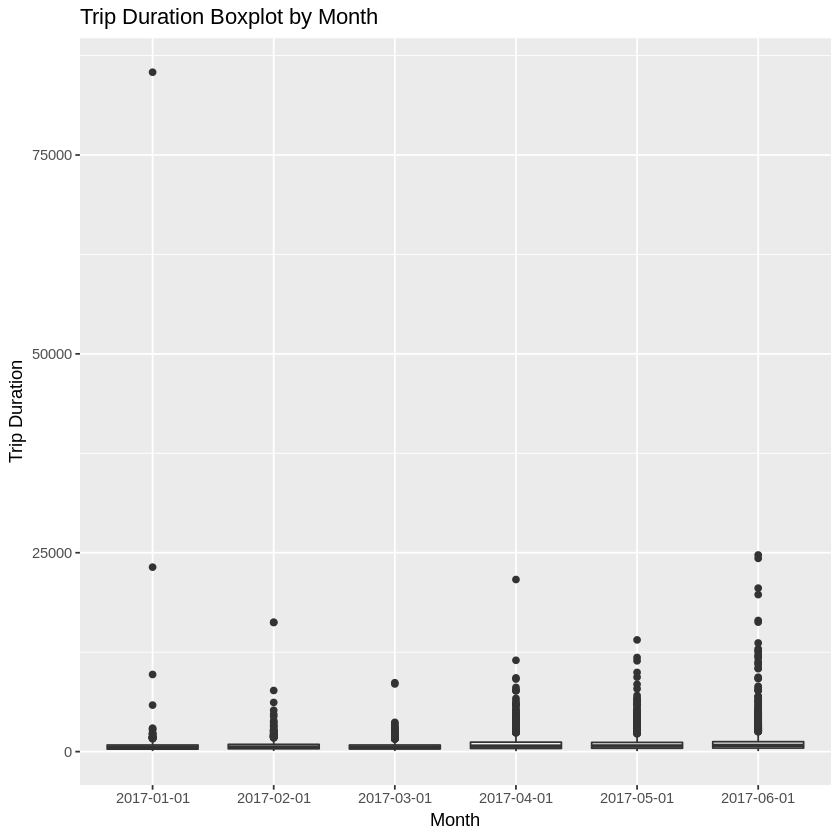

In [15]:
generate_box_plot_for_date <- function(df, 
                                       date.col, 
                                       value.col,
                                       title = 'Title',
                                       xlabel = 'X',
                                       ylabel = 'Y') {
    df[[date.col]] <- as.POSIXct(df[[date.col]])
    df$month <- floor_date(df[[date.col]], 'month')
    df$month <- as.factor(df$month)

    plot <- ggplot(data = df,
                   aes(x = df$month,
                   y = df[[value.col]]
                  )) +
                geom_boxplot() +
                xlab(xlabel) +
                ylab(ylabel) +
                ggtitle(title)
                
    return(plot)
} 

generate_box_plot_for_date(chi, 
                           date.col = 'Start.Time', 
                           value.col = 'Trip.Duration',
                           title = 'Trip Duration Boxplot by Month',
                           xlabel = 'Month',
                           ylabel = 'Trip Duration'
                          )

A max of `85408.0` is a very long duration compared to the mean and median. I don't want my duration calculations to be dramatically skewed by some outlier rides.

The boxplot is squished by this right-tailed data. I'll shave some of the top durations off and get a closer look at the distribution. 

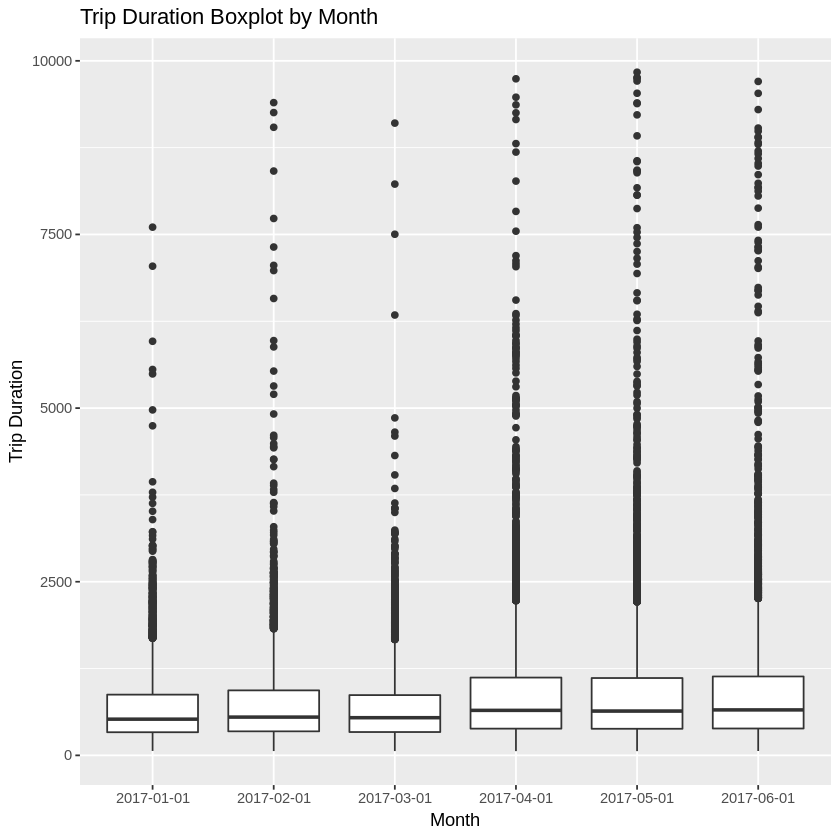

In [16]:
ny %>%
    filter(Trip.Duration < 10000) %>% 
    generate_box_plot_for_date( 
                           date.col = 'Start.Time', 
                           value.col = 'Trip.Duration',
                           title = 'Trip Duration Boxplot by Month',
                           xlabel = 'Month',
                           ylabel = 'Trip Duration'
                          )

That's still too many outliers for me, I'll narrow it down a bit more and proceed with measuring the mean length of rides taken per week.

I decided to summarize by week to encapsulate potential disparities with weekend and weekday ridership (pleasure vs commute riding). This will cover a standard American work week and weekend. A daily count would also be too discrete with six months of data, and number of observations too few. Below is a table with the average trip duration by week number.

In [17]:
chi %>%
    mutate(Start.Time = as.POSIXct(Start.Time)) %>%
    filter(Trip.Duration < 5000) %>% 
    mutate(week = week(Start.Time)) %>%
    group_by(week) %>%
    summarize(avg.duration = mean(Trip.Duration)) -> chi.summ.df
chi.summ.df

week,avg.duration
1,500.5583
2,603.5877
3,730.9057
4,647.8289
5,594.6437
6,628.2303
7,724.0305
8,800.1119
9,613.9570
10,650.2188


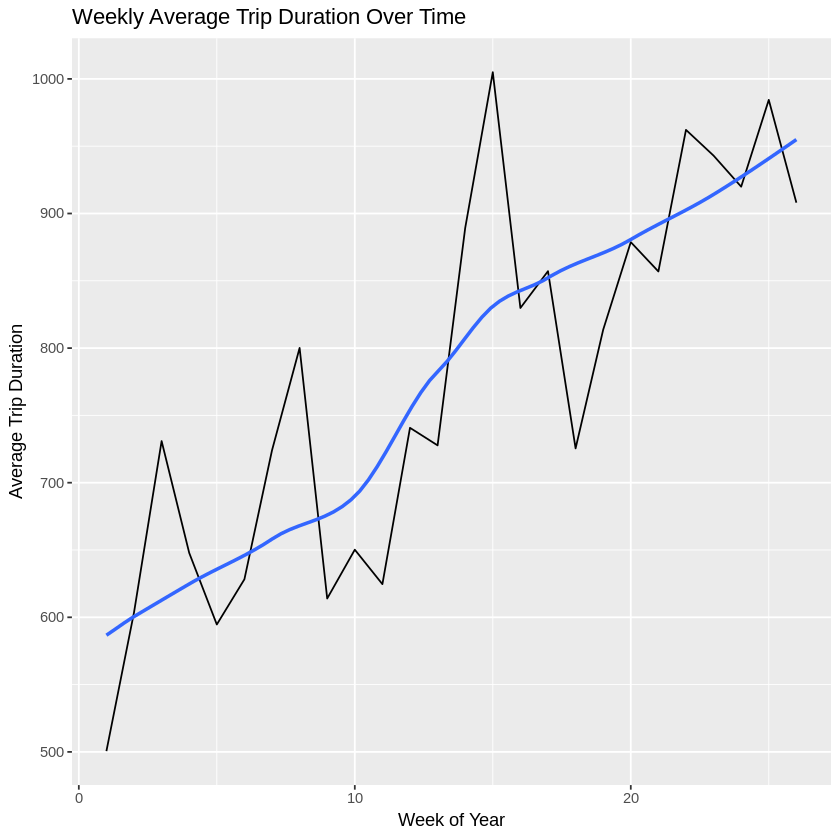

In [18]:
ggplot(chi.summ.df,
        aes(x = week,
               y = avg.duration)
          ) +
        geom_line() +
        xlab('Week of Year') +
        ylab('Average Trip Duration') +
        ggtitle('Weekly Average Trip Duration Over Time') +
        geom_smooth(se = FALSE,
                    method = 'loess',
                    formula = 'y ~ x')

It looks like as each week passes, the general trend is that trip duration increases. A reasonable hypothesis for this increase is improving weather increases rider duration. Such a claim can't be made with this data, but further exploration could be done. 

### Question 2

What is the distribution of rides by age and user type?

For this question, I wanted to to investigate how many rides are taken per age group. I wondered if certain age groups had preferences to being a subscriber and how many rides they took. I started with summary statistics.

In [19]:
ny %>%
    mutate(User.Type = as.factor(User.Type)) %>%
    group_by(Birth.Year, User.Type) %>%
    summarize(user.type.count = n()) %>%
    summary()

   Birth.Year        User.Type  user.type.count
 Min.   :1885             :38   Min.   :   1   
 1st Qu.:1956   Customer  :48   1st Qu.:   3   
 Median :1972   Subscriber:82   Median :  15   
 Mean   :1968                   Mean   : 326   
 3rd Qu.:1986                   3rd Qu.: 357   
 Max.   :2001                   Max.   :4733   
 NA's   :3                                     

A minimum birth year of 1885? That seems a little suspect.

I think it's likely that the clientele of a bikeshare service skews a little younger than 135 years old. I'll start just before the first quartile.

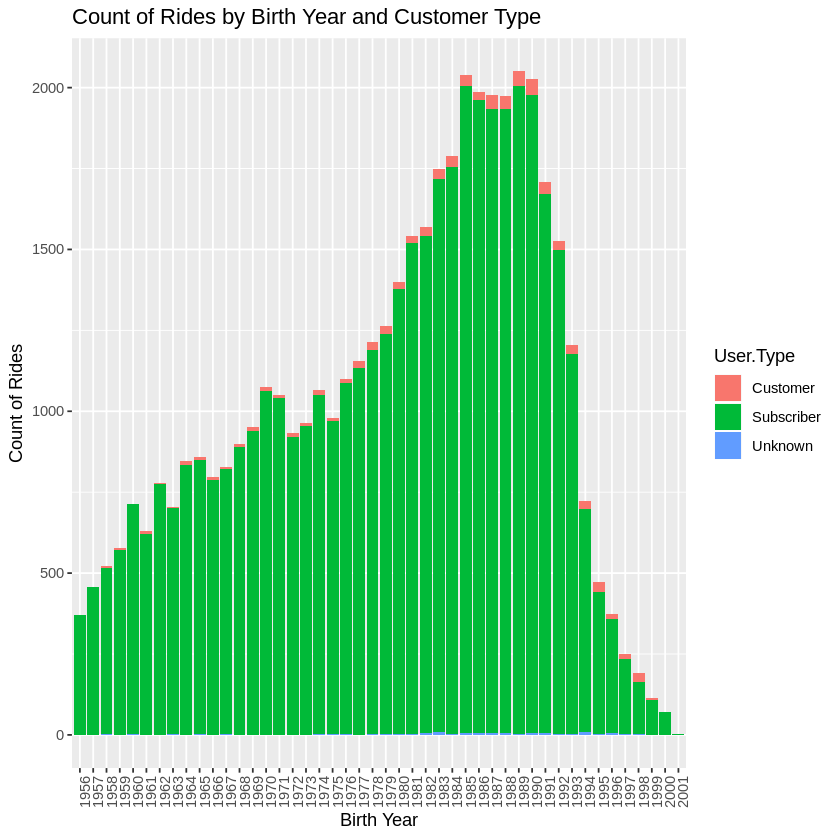

In [20]:
ny %>%
    filter(!is.na(Birth.Year)) %>%
    filter(!is.na(User.Type)) %>%
    filter(Birth.Year > 1955) %>%
    mutate(User.Type = as.character(User.Type)) %>%
    mutate(User.Type = replace(User.Type, User.Type ==  '', 'Unknown')) %>%
    mutate(Birth.Year = as.factor(Birth.Year)) %>%
    mutate(User.Type = as.factor(User.Type)) %>%
    group_by(Birth.Year, User.Type) %>%
    summarize(user.type.count = n()) %>%
    ggplot(aes(x = Birth.Year,
               y = user.type.count,
               group = User.Type,
               fill = User.Type)
          ) +
        geom_bar(stat = 'identity') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    xlab('Birth Year') +
    ylab('Count of Rides') +
    ggtitle('Count of Rides by Birth Year and Customer Type')

With the data cleaned up a bit, it's clear to see that more rides are being taken by older Millenials and younger Gen X people. Springingly, almost ever ride is taken by a subscriber of the bikeshare service. So investigating that didn't turn out to be all that interesting. There also appears to be some bad data, as some `User.Type` fields were blank.

### Question 3

What is the average trip duration for the most popular route?

This question started as a cursory investigation into trips and durations. I wanted to know how many start and ending stations paris there were as it may suggest high traffic areas and popular stations that could use extra attention. So I started with the following:

In [21]:
wash %>%  
    group_by(Start.Station, End.Station) %>%
    summarize(avg.duration = mean(Trip.Duration),
              min.duration = min(Trip.Duration),
              max.duration = max(Trip.Duration),
              num_rides = n()
             ) %>%
    arrange(desc(num_rides)) -> wash.clean

head(wash.clean)

Start.Station,End.Station,avg.duration,min.duration,max.duration,num_rides
Jefferson Dr & 14th St SW,Jefferson Dr & 14th St SW,3663.332,68.336,17823.656,198
Smithsonian-National Mall / Jefferson Dr & 12th St SW,Smithsonian-National Mall / Jefferson Dr & 12th St SW,4171.411,68.831,21716.204,192
Lincoln Memorial,Jefferson Dr & 14th St SW,1977.874,339.901,7664.408,143
Lincoln Memorial,Jefferson Memorial,1626.021,471.720,8942.502,143
Jefferson Dr & 14th St SW,Lincoln Memorial,1821.907,473.960,14019.910,138
Lincoln Memorial,Lincoln Memorial,2415.567,64.957,22940.146,120


I noticed here that several of the top starting and ending stations were the same and dominated the top rides. That meant that many of these rides were not for station to station commuting. People were going in a circle and returning the bike where they picked it up. 

This was more interesting to me than my initial idea so I dug in deeper and added a new column to categorize whether or not the customer returned the bike where they picked it up.

In [26]:
is_same_station <- function(start, end) {
    if(start == end) {
        return(TRUE)
    }
    
    return(FALSE)
}

wash.clean %>%
    rowwise %>%
    mutate(is_same_station = is_same_station(Start.Station, End.Station)) %>%
    summary()

                              Start.Station  
 Massachusetts Ave & Dupont Circle NW:  184  
 Lincoln Memorial                    :  172  
 14th & Rhode Island Ave NW          :  163  
 Jefferson Dr & 14th St SW           :  163  
 1st & M St NE                       :  161  
 New York Ave & 15th St NW           :  161  
 (Other)                             :25375  
                               End.Station     avg.duration     
 Lincoln Memorial                    :  200   Min.   :    78.8  
 Jefferson Dr & 14th St SW           :  184   1st Qu.:   627.6  
 Massachusetts Ave & Dupont Circle NW:  182   Median :   981.3  
 5th St & Massachusetts Ave NW       :  181   Mean   :  1475.9  
 17th & K St NW / Farragut Square    :  177   3rd Qu.:  1482.5  
 Jefferson Memorial                  :  174   Max.   :904591.4  
 (Other)                             :25281   NA's   :1         
  min.duration       max.duration        num_rides       is_same_station
 Min.   :    60.3   Min.   :    78.8   

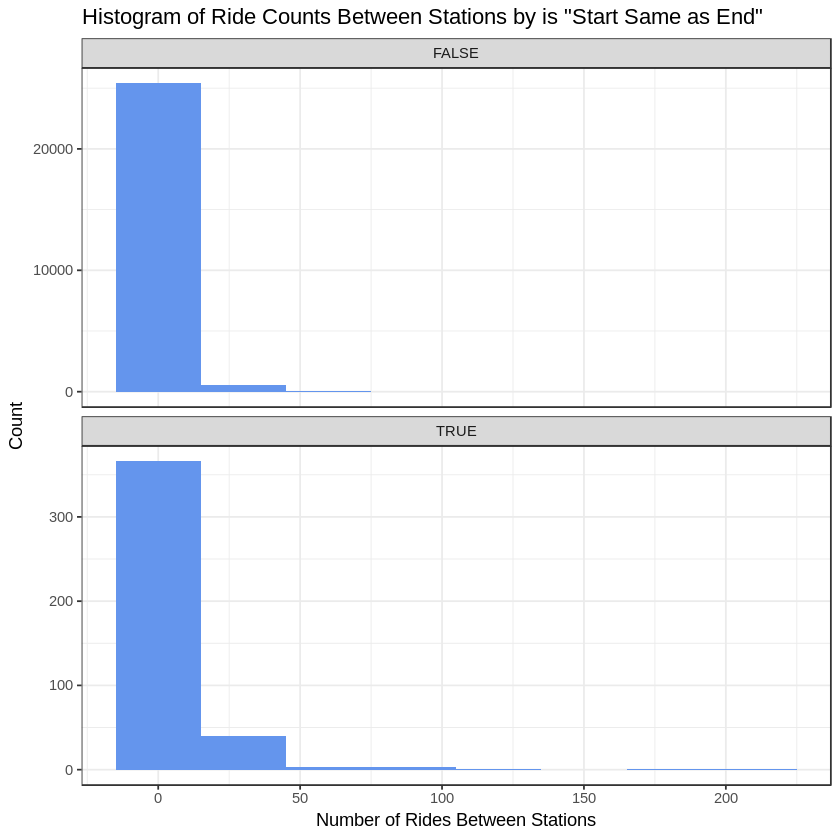

In [27]:
wash.clean %>%
    rowwise %>%
    mutate(is_same_station = is_same_station(Start.Station, End.Station)) %>%
    ggplot(aes(x = num_rides,
              )
          ) +
    theme_bw() +
    geom_histogram(binwidth = 30,
                   fill = 'cornflowerblue'
                   ) +
    facet_wrap(~is_same_station, 
               ncol = 1,
               scales = 'free_y'
              ) +
    xlab('Number of Rides Between Stations') +
    ylab('Count') +
    ggtitle('Histogram of Ride Counts Between Stations by is "Start Same as End"')


So most individual rides have different starting and ending stations. However, the most used stations are the same for start and end. With that investigated, I moved on to my question.

I wanted see the trip durations for the most popular start-stop:

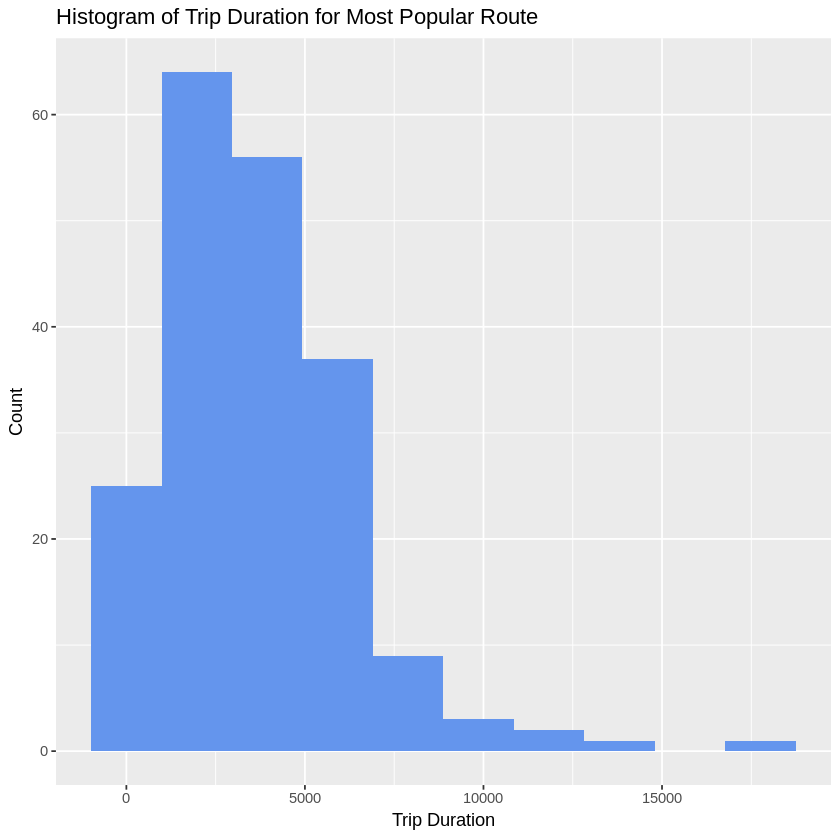

In [24]:
station <- 'Jefferson Dr & 14th St SW'

wash %>%
    filter(Start.Station == station) %>%
    filter(End.Station == station) %>%
    ggplot(aes(x = Trip.Duration)) +
        geom_histogram(bins = 10,
                       fill = 'cornflowerblue'
                      ) +
        xlab('Trip Duration') +
        ylab('Count') +
        ggtitle('Histogram of Trip Duration for Most Popular Route')

In [32]:
wash %>%
    filter(Start.Station == station) %>%
    filter(End.Station == station) -> wash.clean

summary(wash.clean$Trip.Duration)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   68.34  1797.47  3170.52  3663.33  5066.79 17823.66 

So it appears that the average trip is around 1 hour, and most trips are under 90 minutes. I looked up where 'Jefferson Dr & 14th St SW' was on a map. It turns out, this station is right by the Washinton Monument, White House, and the National Mall. One hypothesis is I have is this bike share service has some rate for an hour of use, and tourists use the bikes to look at the attractions. Could be interesting to dig in deeper!


## Finishing Up

> Congratulations!  You have reached the end of the Explore Bikeshare Data Project. You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2508/view). 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
system('python -m nbconvert Explore_bikeshare_data.ipynb')